### The purpose of this notebook is to compare and explore different imputation methods - it is not involved in the actual pipeline of the project

In [1]:
import numpy as np
import pandas as pd
import torch

from imputation_utils import *

# Import data

In [2]:
data, VARIABLES = import_data(discard_variables=True, discard_days=True, THRESHOLD=60)

discarded variables: ['GalvanicSkinResponse', 'ActivityClass']
discarded days (less than 60min of data): [312]
discarded days (sensor out all day): [114]


# Imputation

Format data into daily dataframes (for imputation model)

In [3]:
data_daily = data_to_days(data)

100%|██████████| 408/408 [02:06<00:00,  3.22it/s]


Normalize day-variable-wise

In [4]:
normalize_by_day(data_daily)

day 0 - ActivityCounts: mean: 1.2688263138573217e-17, std: 0.9999999999999959
day 0 - Barometer: mean: -5.938107148852266e-14, std: 0.9999999999999997
day 0 - BloodPerfusion: mean: 2.3770417019099194e-16, std: 1.000000000000001
day 0 - BloodPulseWave: mean: 1.092154295472125e-16, std: 1.0000000000000004
day 0 - EnergyExpenditure: mean: -5.075305255429287e-17, std: 1.0000000000000064
day 0 - HR: mean: -9.765144288927236e-16, std: 1.0
day 0 - HRV: mean: 1.5650721051984586e-16, std: 0.9999999999999997
day 0 - RESP: mean: -3.760906729921135e-16, std: 0.9999999999999998
day 0 - Steps: mean: -3.6478756523398e-17, std: 0.9999999999999938
day 0 - SkinTemperature: mean: 2.816794416763254e-15, std: 0.999999999999999
day 1 - ActivityCounts: mean: 0.0, std: 0.9999999999999909
day 1 - Barometer: mean: 7.088903107932162e-14, std: 0.9999999999999981
day 1 - BloodPerfusion: mean: -3.120978341552417e-17, std: 0.9999999999999994
day 1 - BloodPulseWave: mean: 6.241956683104833e-17, std: 0.999999999999999

### Explore imputation methods

In [5]:
# choose day
day = 400
data_day = data_daily[day]

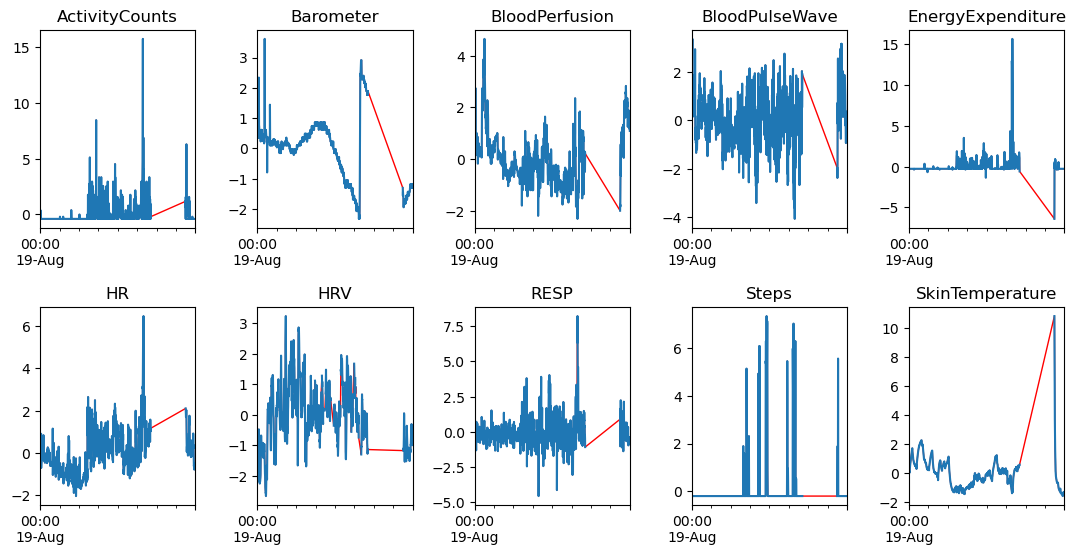

In [8]:
visualize_imputation(data_day, 'linear', order=None, model=None, device='cpu')

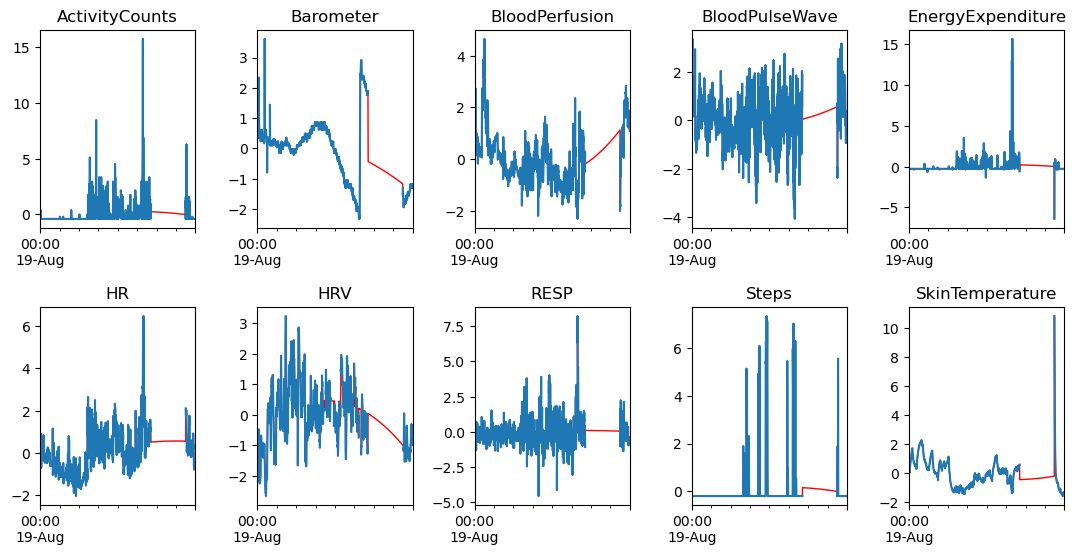

In [9]:
visualize_imputation(data_day, 'spline', order=2, model=None, device='cpu')

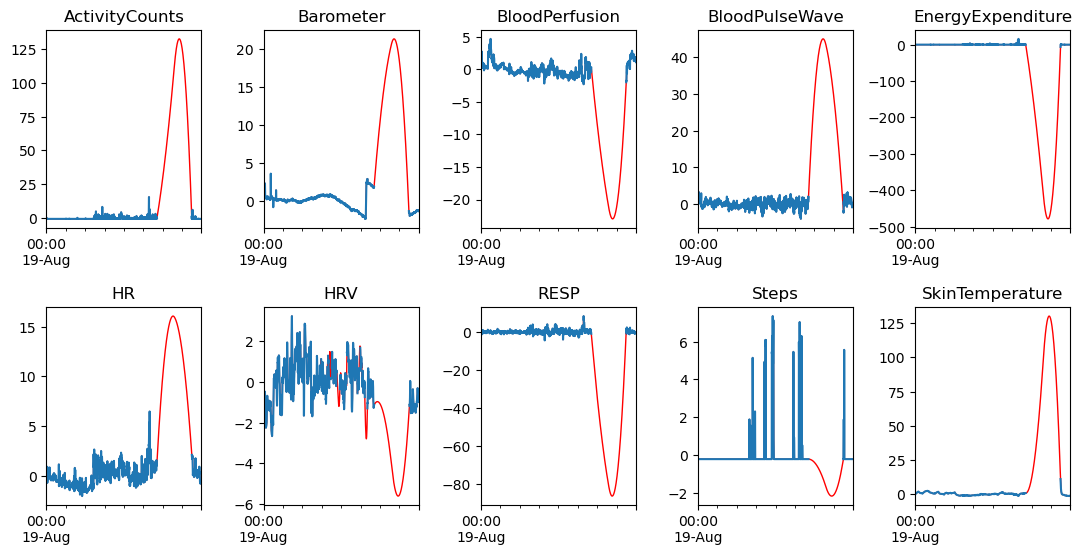

In [11]:
visualize_imputation(data_day, 'quadratic', order=None, model=None, device='cpu')

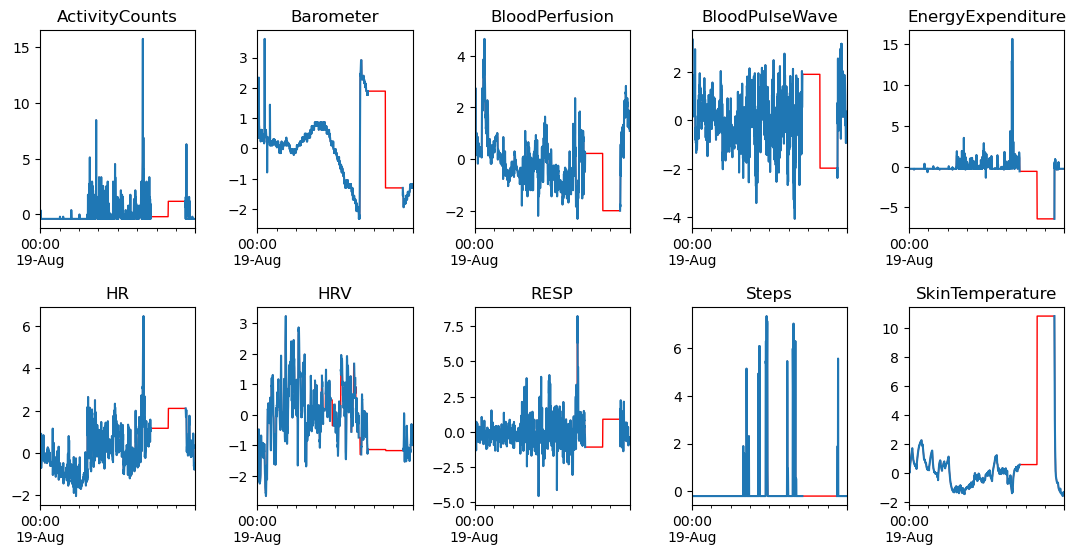

In [12]:
visualize_imputation(data_day, 'nearest', order=None, model=None, device='cpu')

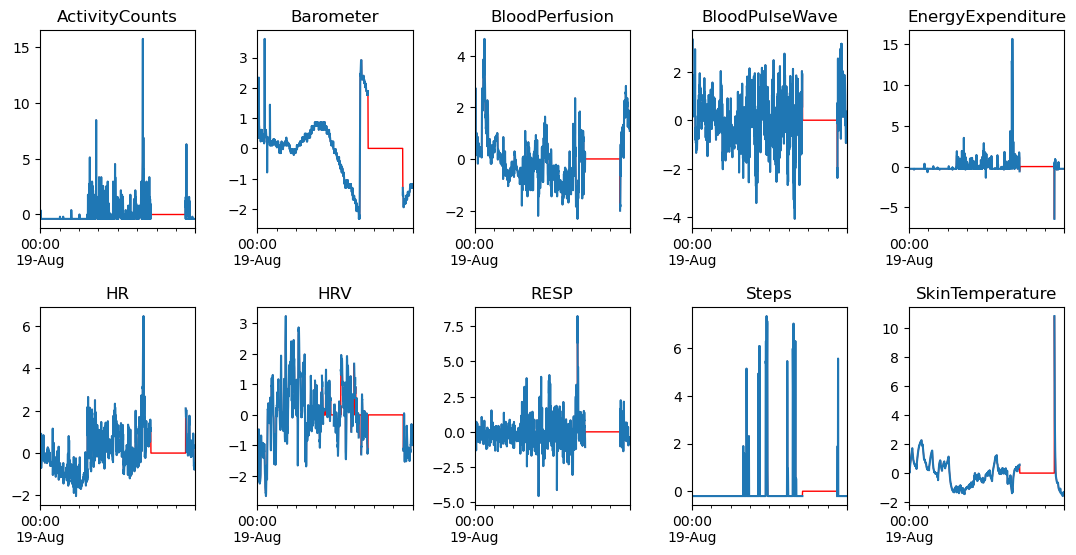

In [13]:
visualize_imputation(data_day, 'mean', order=None, model=None, device='cpu')

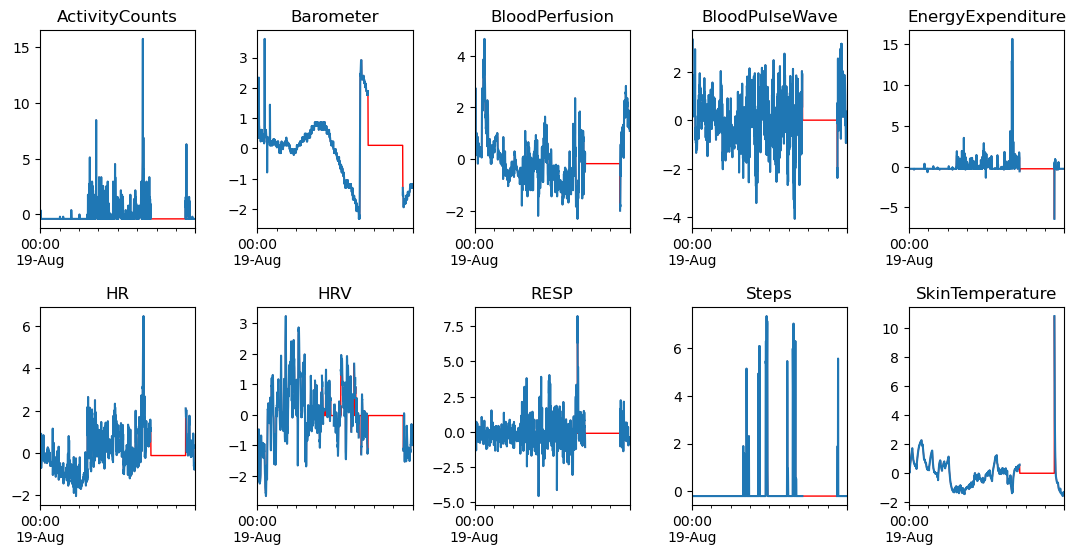

In [14]:
visualize_imputation(data_day, 'median', order=None, model=None, device='cpu')

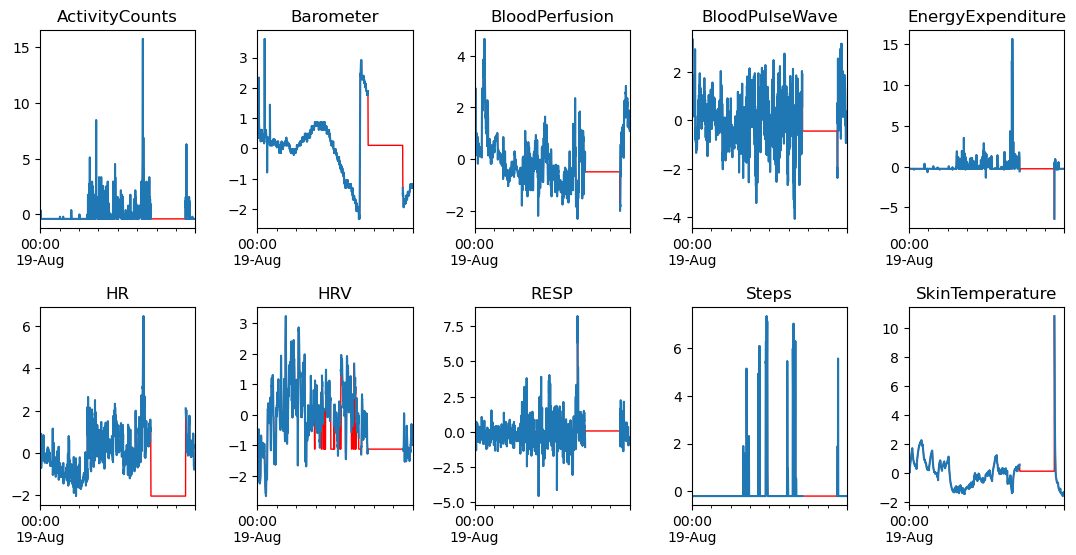

In [15]:
visualize_imputation(data_day, 'mode', order=None, model=None, device='cpu')

### Calculate mean sequence length & masking ratio in actual data

Mean sequence length: lm

In [ ]:
na_seqs = na_sequence_lengths(data)

In [ ]:
na_distribution = [[seq_length]*occurence for seq_length, occurence in na_seqs.to_numpy()]
na_distribution = [element for sublist in na_distribution for element in sublist]

In [ ]:
lm = np.mean(na_distribution) # mean masked sequence
lm

Masking ratio: masking_ratio

In [ ]:
# NaN -> 1.0, available data -> NaN
na_flipped = data.copy(deep=True)
n_days, _ = na_flipped.shape
for day in range(n_days):
    for variable in VARIABLES:
        time_series = get_time_series(na_flipped, variable, day)
        nas = np.isnan(time_series)
        time_series[:] = 1.0 # set full array to 1.0
        time_series[~nas] = np.NaN # set all elements that weren't NaN to NaN

        na_flipped[variable].iloc[day] = time_series

In [ ]:
non_na_seqs = na_sequence_lengths(na_flipped)

In [ ]:
non_na_distribution = [[seq_length]*occurence for seq_length, occurence in non_na_seqs.to_numpy()]
non_na_distribution = [element for sublist in non_na_distribution for element in sublist]

In [51]:
np.mean(non_na_distribution) # mean unmasked sequence

161.50465531381155

In [52]:
r = lm / (np.mean(non_na_distribution) + lm) # masking_ratio
r

0.21195370583292347

Visualize mask

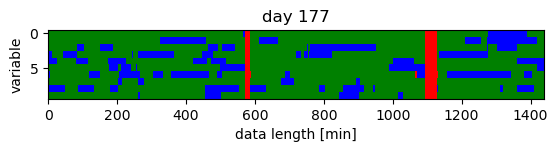

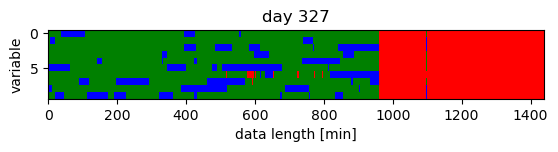

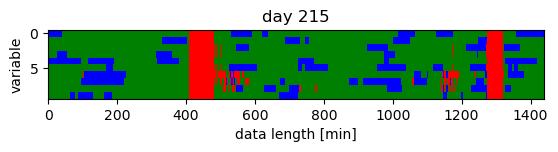

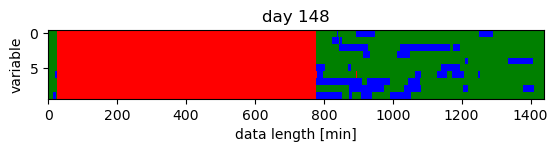

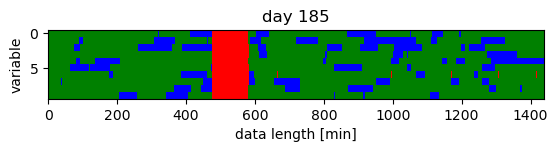

In [54]:
for i in range(5):
    day = np.random.choice(n_days, 1)[0]
    visualize_mask(masker(data_daily[day], lm=lm, masking_ratio=r))

# Transformer imputation

### Model

In [38]:
sequence_length = 1440 # max: 1440 (full day)
d_model = 16
n_heads = 4
n_encoder_layers = 3
lm = 43
r = 0.21

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [41]:
model = TSTransformerEncoder(feat_dim=len(VARIABLES),
                             max_len=sequence_length,
                             d_model=d_model,
                             n_heads=n_heads,
                             num_layers=n_encoder_layers,
                             dim_feedforward=d_model,
                             dropout=0.1,
                             pos_encoding='fixed',
                             activation='gelu',
                             norm='BatchNorm',
                             freeze=False)

model = model.to(device)

In [43]:
# overview of model
model

TSTransformerEncoder(
  (dropout1): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=16, out_features=10, bias=True)
  (project_inp): Linear(in_features=10, out_features=16, bias=True)
  (pos_enc): FixedPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, a

In [44]:
# total number of parameters in model
sum(p.numel() for p in model.parameters())

5434

### Data

In [45]:
# train-test split (TODO: + val?)
from sklearn.model_selection import train_test_split

n_days = len(data_daily)
train_indices, test_indices = train_test_split(np.arange(n_days), random_state=42)
test_data = [data_daily[i] for i in test_indices]

### Training

In [48]:
epochs = 6500
batch_size = 8

criterion = MaskedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
%%time
# segment day into sequences and treat as batches
model.train() # set model into training mode

history = {'train_loss': [],
           'test_loss': []}

print(f'Starting training for {epochs} epochs')
for epoch in tqdm(range(epochs)):
    # loss, metrics
    epoch_loss = 0.0
    epoch_loss_test = 0.0

    # training in batches
    for i, batch_index in enumerate(train_indices):
        # load training batch
        full_day = data_daily[batch_index].copy()

        # create mask (on-the-fly) (0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning))
        mask = masker(full_day, lm=lm, masking_ratio=r)

        # reshape
        full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
        mask = mask.transpose()

        # split day into batches
        n_batches = full_day.shape[0] // sequence_length
        batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
        mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

        # mask missing data
        y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
        batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
        batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
        X = batch

        # predict
        optimizer.zero_grad()
        y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

        # update model
        mask = torch.tensor(mask == 1.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        #mask = torch.tensor(mask != 2.0).unsqueeze(0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        loss = criterion(y_pred, y_true, mask=mask)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()

        # on epoch end shuffle data
        np.random.shuffle(train_indices)

    # validation in batches
    with torch.no_grad():
        for i, batch_index in enumerate(test_indices):
            # load training batch
            full_day = data_daily[batch_index].copy()

            # create mask (on-the-fly) (0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning))
            mask = masker(full_day, lm=43, masking_ratio=0.21)

            # reshape
            full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
            mask = mask.transpose()

            # split day into batches
            n_batches = full_day.shape[0] // sequence_length
            batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
            mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

            # mask missing data
            y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
            batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
            batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
            X = batch

            # predict
            y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

            # update model
            mask = torch.tensor(mask == 1.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
            #mask = torch.tensor(mask != 2.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
            loss = criterion(y_pred, y_true, mask=mask)
            epoch_loss_test += loss.item()

            # on epoch end shuffle data
            np.random.shuffle(test_indices)

    # save data
    with torch.no_grad():
        history['train_loss'].append(epoch_loss / len(train_indices))
        history['test_loss'].append(epoch_loss_test / len(test_indices))

    # print
    #print(f'Epochs {epoch + 1}/{epochs} - train loss: {epoch_loss / len(train_indices)}, test loss: {epoch_loss_test / len(test_indices)}')

Starting training for 6500 epochs


100%|██████████| 6500/6500 [26:31:09<00:00, 14.69s/it]   

CPU times: total: 1d 2h 30min 3s
Wall time: 1d 2h 31min 9s


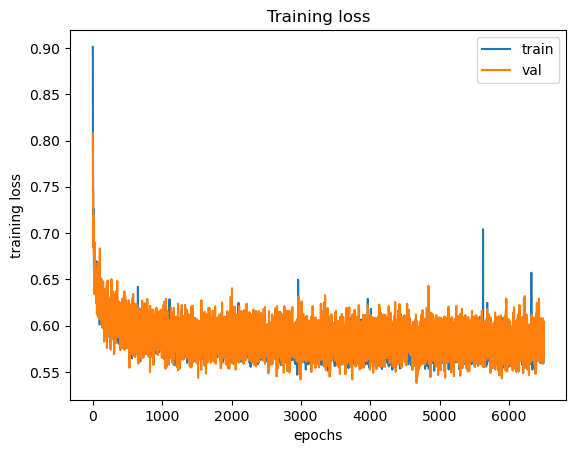

In [15]:
plt.plot(history['train_loss'])
plt.plot(history['test_loss'])
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('Training loss')
plt.legend(['train', 'val'])

### Save model

In [ ]:
torch.save(model, f'./Models/transformer_imputation{epochs}')

### Save data

In [ ]:
np.save(f'./Models/training_data{epochs}', [data_daily[i] for i in train_indices])
np.save(f'./Models/test_data{epochs}', test_data)

# Evaluation

### Optional: load model + data

In [25]:
sequence_length = 48 # max: 1440 (full day)
d_model = 16
n_heads = 4
n_encoder_layers = 3
lm = 43
r = 0.21

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = torch.load('Models/transformer_imputation6500')
test_data = np.load('Models/test_data6500.npy')
test_data = [pd.DataFrame(dat) for dat in test_data]
test_indices = np.arange(len(test_data))

cuda


### a) Visual inspection

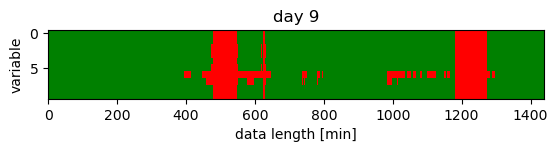

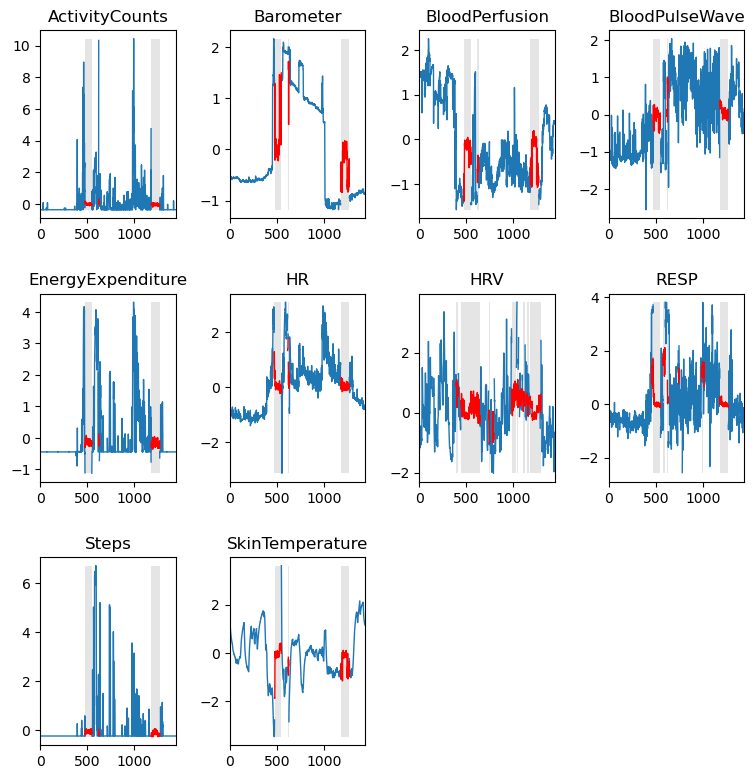

In [21]:
# transformer imputed values
day = np.random.choice(test_indices, 1)[0]
show_prediction(model, data_daily, day, lm=lm, r=r,
                show_mask=True, show_mask_plot=True,
                prediction_only=False, full_prediction=False,
                device=device)

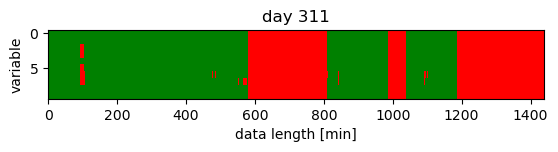

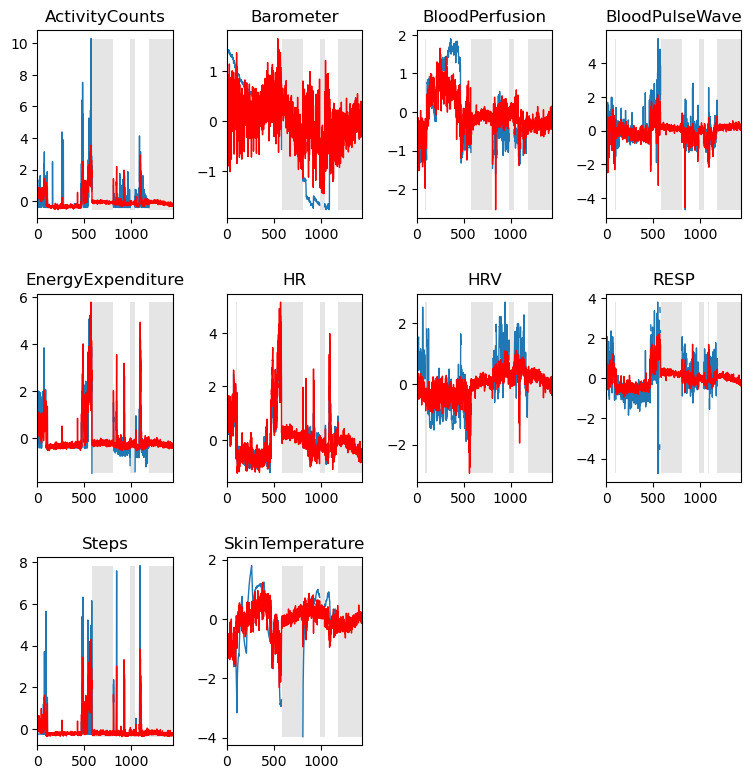

In [55]:
# FULL transformer output
show_prediction(model, data_daily, day, lm=lm, r=r,
                show_mask=True, show_mask_plot=True,
                prediction_only=False, full_prediction=True,
                device=device)

### b) Numeric evaluation

evaluate n times

In [23]:
N = 100

1. Performance scores

In [141]:
i = 0
scores = []
while i < N:
    try:
        temp = test_imputation_methods(test_data,
                                       lm=lm,
                                       masking_ratio=r,
                                       model=model,
                                       device=device)
    except ValueError:
        continue
    if np.any(np.isnan(np.array([element[1] for element in temp]).ravel())):
        pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: divide by zero encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: di

In [142]:
dictify = lambda x: [{vals[0]: vals[1] for vals in score} for score in x]
scores = dictify(scores)

In [143]:
scores

[{'transformer': (0.49761529626615625,
   2.601104040814163,
   0.7683655976996338,
   0.6412737124224793,
   0.6403678840379017),
  'linear': (0.5251587458395998,
   4.0653538515061065,
   0.9648768709474138,
   0.49345367839328974,
   0.6177417858427948),
  'nearest': (0.561137867188754,
   4.487039673502599,
   1.0709567843464773,
   0.4547074644055132,
   0.6018731941909512),
  'spline': (0.6505813694913141,
   3.2915876396741806,
   0.9803551723111482,
   0.3129517572452012,
   0.4099967535841081),
  'median': (0.6686783880884493,
   2.1792204962817014,
   1.0655247626969244,
   -0.11057181221818685,
   -0.032586075722125706),
  'mean': (0.7296611053175177,
   1.5245929552474122,
   1.0339992408612828,
   -0.26151126355314835,
   -0.297968249051605),
  'mode': (0.9655186179040083,
   7.460080556239189,
   1.5308385020335493,
   -0.028988067296910346,
   0.0033397078737923015),
  'quadratic': (94.42156404842949,
   310.3794097851243,
   3208.23669293788,
   -0.00358440225169896,
  

In [144]:
# get means
ROUNDING = 3
tables = []
imputation_methods = list(scores[0].keys())
rows = []
for imputation_method in imputation_methods:
    meanify = lambda x: np.round(np.mean(x), ROUNDING)
    stdify = lambda x: np.round(np.std(x), ROUNDING)

    n_metrics = len(list(scores[0].values())[0])

    means = [meanify([score[imputation_method][i] for score in scores]) for i in range(n_metrics)]
    stds = [stdify([score[imputation_method][i] for score in scores]) for i in range(n_metrics)]

    # only for sorting later
    row = [means[0]]

    row += [str(mean) + ' ± ' + str(std) for mean, std in zip(means, stds)]
    rows.append(row)

table = pd.DataFrame(rows)
table.columns = ['temp', 'MAE', 'MRE', 'RMSE', 'r_{\mathrm{Pearson}}', '\\rho_{\mathrm{Spearman}}']
table.index = [imputation_method.capitalize() for imputation_method in imputation_methods]

In [145]:
# sort by MAE (mean)
table = table.sort_values(by=['temp'])
table = table.drop(columns=['temp'])
table

,MAE,MRE,RMSE,r_{\mathrm{Pearson}},\rho_{\mathrm{Spearman}}
Transformer,0.495 ± 0.005,3.094 ± 0.951,0.759 ± 0.008,0.649 ± 0.006,0.643 ± 0.006
Linear,0.511 ± 0.009,4.575 ± 1.324,0.957 ± 0.032,0.509 ± 0.017,0.626 ± 0.008
Nearest,0.548 ± 0.009,5.136 ± 1.546,1.064 ± 0.037,0.469 ± 0.017,0.607 ± 0.008
Median,0.668 ± 0.007,2.18 ± 0.348,1.06 ± 0.01,-0.096 ± 0.01,-0.019 ± 0.011
Spline,0.7 ± 0.133,3.956 ± 0.823,4.049 ± 11.157,0.204 ± 0.112,0.415 ± 0.01
Mean,0.729 ± 0.005,1.519 ± 0.179,1.027 ± 0.009,-0.254 ± 0.007,-0.281 ± 0.008
Mode,0.946 ± 0.016,7.556 ± 1.607,1.502 ± 0.028,-0.018 ± 0.01,0.015 ± 0.013
Quadratic,172.244 ± 102.692,1081.808 ± 1324.524,6644.463 ± 5308.724,0.002 ± 0.011,0.255 ± 0.013


In [146]:
# make smallest bold
for col in range(len(table.columns)):
    if col in (3, 4): # correlation: higher is better
        index_best = np.argmax([abs(float(entry.split('±')[0])) for entry in table.iloc[:, col]])
    else:
        index_best = np.argmin([float(entry.split('±')[0]) for entry in table.iloc[:, col]])
    entry = table.iloc[index_best, col]
    entry = 'BOLD{' + entry + '}'
    table.iloc[index_best, col] = entry

In [147]:
df = table
caption = f'Imputation metrics (n=100)'
print(
    df.to_latex(
        index=True,
        bold_rows=True,
        caption=caption,
        position='H').replace('BOLD\\', r'\textbf').replace('\}', '}').replace('\_', '_').replace('\\textbackslash', '\\').replace(r'\{', r'{').replace('\\ ', '\\')
)

\begin{table}[H]
\centering
\caption{Imputation metrics (n=100)}
\begin{tabular}{llllll}
\toprule
{} &                  MAE &                  MRE &                 RMSE & r_{\mathrm{Pearson}} & \rho_{\mathrm{Spearman}} \\
\midrule
\textbf{Transformer} &  \textbf{0.495 ± 0.005} &        3.094 ± 0.951 &  \textbf{0.759 ± 0.008} &  \textbf{0.649 ± 0.006} &      \textbf{0.643 ± 0.006} \\
\textbf{Linear     } &        0.511 ± 0.009 &        4.575 ± 1.324 &        0.957 ± 0.032 &        0.509 ± 0.017 &            0.626 ± 0.008 \\
\textbf{Nearest    } &        0.548 ± 0.009 &        5.136 ± 1.546 &        1.064 ± 0.037 &        0.469 ± 0.017 &            0.607 ± 0.008 \\
\textbf{Median     } &        0.668 ± 0.007 &         2.18 ± 0.348 &          1.06 ± 0.01 &        -0.096 ± 0.01 &           -0.019 ± 0.011 \\
\textbf{Spline     } &          0.7 ± 0.133 &        3.956 ± 0.823 &       4.049 ± 11.157 &        0.204 ± 0.112 &             0.415 ± 0.01 \\
\textbf{Mean       } &        0.729 ± 0.0

C:\Users\jjung\AppData\Local\Temp\ipykernel_15212\452253745.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


In [149]:
scores_all = scores
tables_all = table

2. Imputation by variable

In [136]:
i = 0
scores = []
while i < N:
    try:
        temp = test_imputation_methods_by_variable(test_data,
                                                   lm=lm,
                                                   masking_ratio=r,
                                                   model=model,
                                                   device=device)
    except ValueError:
        continue

    values = [list(temp[method][variable]) for method in temp.keys() for variable in temp[method].keys()]
    if np.any(np.isnan(values)):
        pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: divide by zero encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: di

In [137]:
scores

[{'mean': {'ActivityCounts': (0.577028574036915,
    1.0986561937713866,
    1.030869872054979,
    -0.16216120655914026,
    -0.188092400326965),
   'Barometer': (0.8571796585794985,
    1.1707504472753376,
    1.0318460258364335,
    -0.29079545656979133,
    -0.3178348229873421),
   'BloodPerfusion': (0.8710981205859858,
    1.2731753436866755,
    1.076214623883953,
    -0.29910631598711607,
    -0.3193354509816525),
   'BloodPulseWave': (0.7632712517969458,
    1.4863642287539822,
    1.012875698497522,
    -0.22087375712428495,
    -0.26068570474530556),
   'EnergyExpenditure': (0.6374659827900084,
    1.139996943190404,
    1.0795535412139665,
    -0.22553143267076117,
    -0.20022993003844378),
   'HR': (0.8180192325008069,
    1.8133663845449917,
    1.0585380165471956,
    -0.2628346564568839,
    -0.2982705224548057),
   'HRV': (0.801597959276951,
    2.8116684597720822,
    1.008564189082814,
    -0.26088794426187,
    -0.27034275221732545),
   'RESP': (0.7701497297430118,


In [138]:
# get means
ROUNDING = 3
tables = []
imputation_methods = list(scores[0].keys())
for imputation_method in imputation_methods:
    rows = []
    for variable in VARIABLES:
        meanify = lambda x: np.round(np.mean(x), ROUNDING)
        stdify = lambda x: np.round(np.std(x), ROUNDING)

        n_metrics = len(scores[0]['mean'][VARIABLES[0]])

        means = [meanify([score[imputation_method][variable][i] for score in scores]) for i in range(n_metrics)]
        stds = [stdify([score[imputation_method][variable][i] for score in scores]) for i in range(n_metrics)]

        # only for sorting later
        row = [means[0]]

        row += [str(mean) + ' ± ' + str(std) for mean, std in zip(means, stds)]
        rows.append(row)

    table = pd.DataFrame(rows)
    table.columns = ['temp', 'MAE', 'MRE', 'RMSE', 'r_{\mathrm{Pearson}}', '\\rho_{\mathrm{Spearman}}']
    table.index = [variable for variable in VARIABLES]

    # sort by MAE (mean)
    table = table.sort_values(by=['temp'])
    table = table.drop(columns=['temp'])

    # make smallest bold
    for col in range(len(table.columns)):
        if col in (3, 4): # correlation: higher is better
            index_best = np.argmax([abs(float(entry.split('±')[0])) for entry in table.iloc[:, col]])
        else:
            index_best = np.argmin([float(entry.split('±')[0]) for entry in table.iloc[:, col]])
        entry = table.iloc[index_best, col]
        entry = 'BOLD{' + entry + '}'
        table.iloc[index_best, col] = entry

    tables.append(table)

In [139]:
for i, imputation_method in enumerate(imputation_methods):
    df = tables[i]
    caption = r'\textbf{' + imputation_method.capitalize() + '}'
    caption += f'-imputation by variable (n=100)'
    print(
        df.to_latex(
            index=True,
            bold_rows=True,
            caption=caption,
            position='H').replace('BOLD\\', r'\textbf').replace('\}', '}').replace('\_', '_').replace('\\textbackslash', '\\').replace(r'\{', r'{').replace('\\ ', '\\')
    )

\begin{table}[H]
\centering
\caption{\textbf{Mean}-imputation by variable (n=100)}
\begin{tabular}{llllll}
\toprule
{} &                  MAE &                 MRE &                 RMSE & r_{\mathrm{Pearson}} & \rho_{\mathrm{Spearman}} \\
\midrule
\textbf{Steps            } &  \textbf{0.464 ± 0.014} &  \textbf{1.046 ± 0.03} &  \textbf{0.983 ± 0.042} &       -0.179 ± 0.017 &           -0.154 ± 0.082 \\
\textbf{ActivityCounts   } &        0.568 ± 0.011 &       1.141 ± 0.049 &        1.013 ± 0.033 &       -0.168 ± 0.016 &           -0.187 ± 0.042 \\
\textbf{EnergyExpenditure} &        0.609 ± 0.016 &        1.16 ± 0.118 &        1.025 ± 0.041 &       -0.215 ± 0.018 &            -0.199 ± 0.05 \\
\textbf{RESP             } &        0.758 ± 0.011 &       1.545 ± 0.238 &        1.019 ± 0.017 &       -0.197 ± 0.017 &           -0.219 ± 0.019 \\
\textbf{BloodPulseWave   } &        0.759 ± 0.014 &        1.47 ± 0.209 &         1.02 ± 0.019 &        -0.21 ± 0.017 &            -0.234 ± 0.02 \\
\t

C:\Users\jjung\AppData\Local\Temp\ipykernel_15212\3364508060.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


In [140]:
scores_var = scores
tables_var = tables

3. Imputation by sequence length

In [122]:
i = 0
scores = []
while i < N:
    try:
        temp = test_imputation_methods_by_sequence(test_data,
                                                   lm=lm,
                                                   masking_ratio=r,
                                                   model=model,
                                                   device=device)
    except ValueError:
        continue

    values = [list(temp[method][sequence]) for method in temp.keys() for sequence in temp[method].keys()]
    if np.any(np.isnan(values)):
        pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\AppData\Local\Temp\ipykernel_15212\966842015.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imputed_data = np.concatenate(np.array(imputations)[selection])
C:\Users\jjung\AppData\Local\Temp\ipykernel_15212\966842015.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  real_data = np.concatenate(np.array(reals)[selection])
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(

In [123]:
scores

[{'mean': {'small': (0.8750309915444588,
    1.1449364793839878,
    1.2894280611954891,
    -0.054866224217118134,
    -0.05951330730091203),
   'medium': (0.7370535926196161,
    1.5454219545889207,
    1.0353993087215567,
    -0.13760224799037304,
    -0.14917264001511876),
   'long': (0.7169644947797251,
    1.816453032022086,
    0.9910631067322921,
    -0.33423174106536785,
    -0.372414920545056)},
  'median': {'small': (0.8316193273699692,
    1.3411284132792338,
    1.323368161579498,
    -0.057914847150984654,
    0.02324451601396199),
   'medium': (0.6825964895774942,
    1.8913869954565445,
    1.0694622382664316,
    -0.04242014797264228,
    0.04198553541748292),
   'long': (0.6558789166341255,
    3.1146043265162047,
    1.0273668512937086,
    -0.1528158733486802,
    -0.08414998471353037)},
  'mode': {'small': (1.1658728996507777,
    4.890666263539724,
    1.8383095818076294,
    -0.060648142801714364,
    -0.024860603826756783),
   'medium': (0.9805260405184001,
    

In [130]:
# get means
ROUNDING = 3
tables = []
imputation_methods = list(scores[0].keys())
for imputation_method in imputation_methods:
    rows = []
    for sequence in ('small', 'medium', 'long'):
        meanify = lambda x: np.round(np.mean(x), ROUNDING)
        stdify = lambda x: np.round(np.std(x), ROUNDING)

        n_metrics = len(scores[0]['mean']['small'])

        means = [meanify([score[imputation_method][sequence][i] for score in scores]) for i in range(n_metrics)]
        stds = [stdify([score[imputation_method][sequence][i] for score in scores]) for i in range(n_metrics)]

        # only for sorting later
        row = [means[0]]

        row += [str(mean) + ' ± ' + str(std) for mean, std in zip(means, stds)]
        rows.append(row)

    table = pd.DataFrame(rows)
    table.columns = ['temp', 'MAE', 'MRE', 'RMSE', 'r_{\mathrm{Pearson}}', '\\rho_{\mathrm{Spearman}}']
    table.index = ['Small sequences', 'Medium sequences', 'Long sequences']

    # sort by MAE (mean)
    table = table.sort_values(by=['temp'])
    table = table.drop(columns=['temp'])

    # make smallest bold
    for col in range(len(table.columns)):
        if col in (3, 4): # correlation: higher is better
            index_best = np.argmax([abs(float(entry.split('±')[0])) for entry in table.iloc[:, col]])
        else:
            index_best = np.argmin([float(entry.split('±')[0]) for entry in table.iloc[:, col]])
        entry = table.iloc[index_best, col]
        entry = 'BOLD{' + entry + '}'
        table.iloc[index_best, col] = entry

    tables.append(table)

In [125]:
for i, imputation_method in enumerate(imputation_methods):
    df = tables[i]
    caption = r'\textbf{' + imputation_method.capitalize() + '}'
    caption += f'-imputation by sequence length (n=100)'
    print(
        df.to_latex(
            index=True,
            bold_rows=True,
            caption=caption,
            position='H').replace('BOLD\\', r'\textbf').replace('\}', '}').replace('\_', '_').replace('\\textbackslash', '\\').replace(r'\{', r'{').replace('\\ ', '\\')
    )

\begin{table}[H]
\centering
\caption{\textbf{Mean}-imputation by sequence length (n=100)}
\begin{tabular}{llllll}
\toprule
{} &                 MAE &                  MRE &                RMSE & r_{\mathrm{Pearson}} & \rho_{\mathrm{Spearman}} \\
\midrule
\textbf{Long sequences  } &  \textbf{0.72 ± 0.008} &         1.62 ± 0.273 &  \textbf{1.01 ± 0.014} &  \textbf{-0.33 ± 0.013} &     \textbf{-0.365 ± 0.013} \\
\textbf{Medium sequences} &       0.736 ± 0.009 &        1.455 ± 0.242 &       1.041 ± 0.015 &       -0.132 ± 0.016 &           -0.149 ± 0.017 \\
\textbf{Small sequences } &       0.853 ± 0.018 &  \textbf{1.296 ± 0.224} &       1.236 ± 0.037 &       -0.018 ± 0.026 &           -0.027 ± 0.027 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{\textbf{Median}-imputation by sequence length (n=100)}
\begin{tabular}{llllll}
\toprule
{} &                  MAE &                  MRE &                 RMSE & r_{\mathrm{Pearson}} & \rho_{\mathrm{Spearman}} \\
\mi

C:\Users\jjung\AppData\Local\Temp\ipykernel_15212\276566941.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


In [131]:
scores_seq = scores
tables_seq = tables

### Save all scores/tables

In [159]:
save_path = './Scores/imputation/'

In [165]:
for imputation_method, table in zip(list(scores_seq[0].keys()), tables_seq):
    table.to_csv(save_path + 'imputation_by_sequence_' + str(imputation_method) + '.csv')

In [168]:
for imputation_method, table in zip(list(scores_var[0].keys()), tables_var):
    table.to_csv(save_path + 'imputation_by_variable_' + str(imputation_method) + '.csv')

In [ ]:
tables_all.to_csv(save_path + 'imputation_all_methods' + '.csv')